# Selecting spectral lines

In [1]:
import pandas as pd
import spectrograph as sg
import matplotlib
import matplotlib.pyplot as plt
#from colorspacious import cspace_converter
import numpy as np
import scipy as sp
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%matplotlib notebook
%reload_ext autoreload
%autoreload 2

In [3]:
kwargs = {
    "datafile": "ThAr2D_voie_3_new.json",
    'bootstrap_data': False,
    'n_bootstrap': 100,                             # number of bootstrap experiments
    'profile': 'gauss',
    'loss_function': 'loss_1',                     # weighted L2-loss
    'save_bootstraped_data': False,
    'bootstraped_file': 'ThAr2D_voie_3_new.json',
    'epsilon_sigma_bootstrap': 3,         # locations with larger uncertainty are removed
    'epsilon_sigma_clipp': 3,
    'epsilon_sigma_clipp_2d' : 2,
    'clipp_method' : 'rel_std',             # 'rel_std' or 'pixerror' or 'est_std'
    'orders': np.arange(23, 59+1),          # orders to use, set None if taken from data
    'palette_order': 'gist_rainbow',
    'order_ol': 6,
    'order_o': 7,
    'n_sigma_clip' : 100,
    'sigma_min' : 0.,                    # minimial sigma to avoid overfitting
    'file_lambda_list': 'arturo.dat',
}

data = sg.CCD2d(**kwargs)
data.sigma_clipping()

In [ ]:
data.data

We now write all order as a single function $x = f(\lambda o)$

<IPython.core.display.Javascript object>


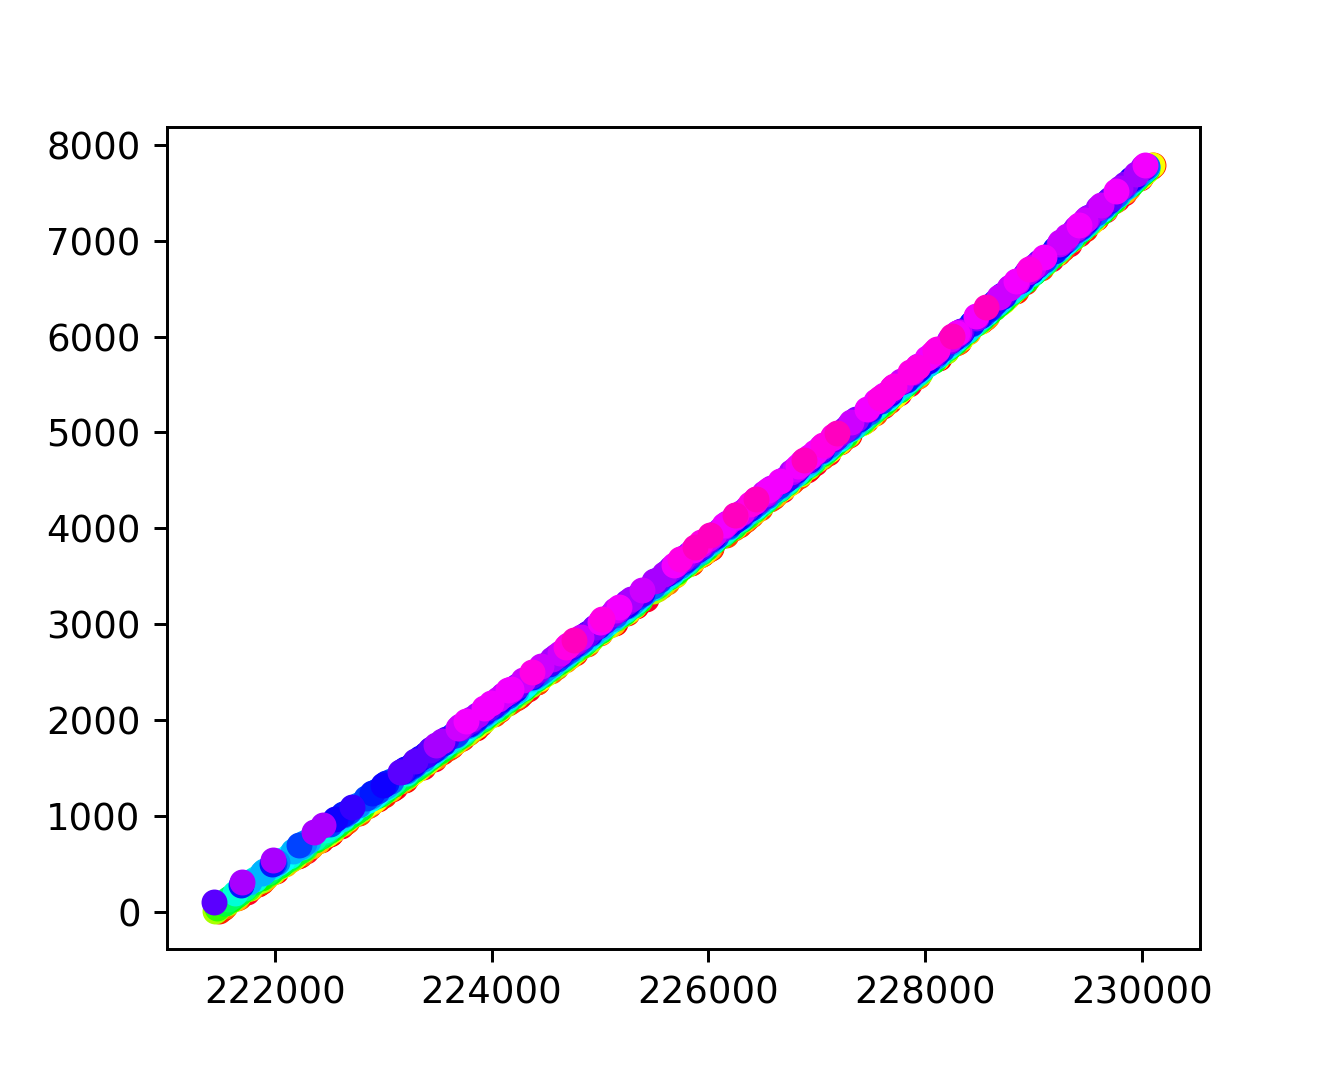

In [72]:
plt.figure(figsize=(5,4))
for o in data.get_orders():
    I = data.index_order(o)
    #print (data.x[I])
    plt.plot(data.o[I]*data.l[I], data.x[I], 'o', color=data.color_of_order(o))

Removing a first global polynomial of low order..

<IPython.core.display.Javascript object>


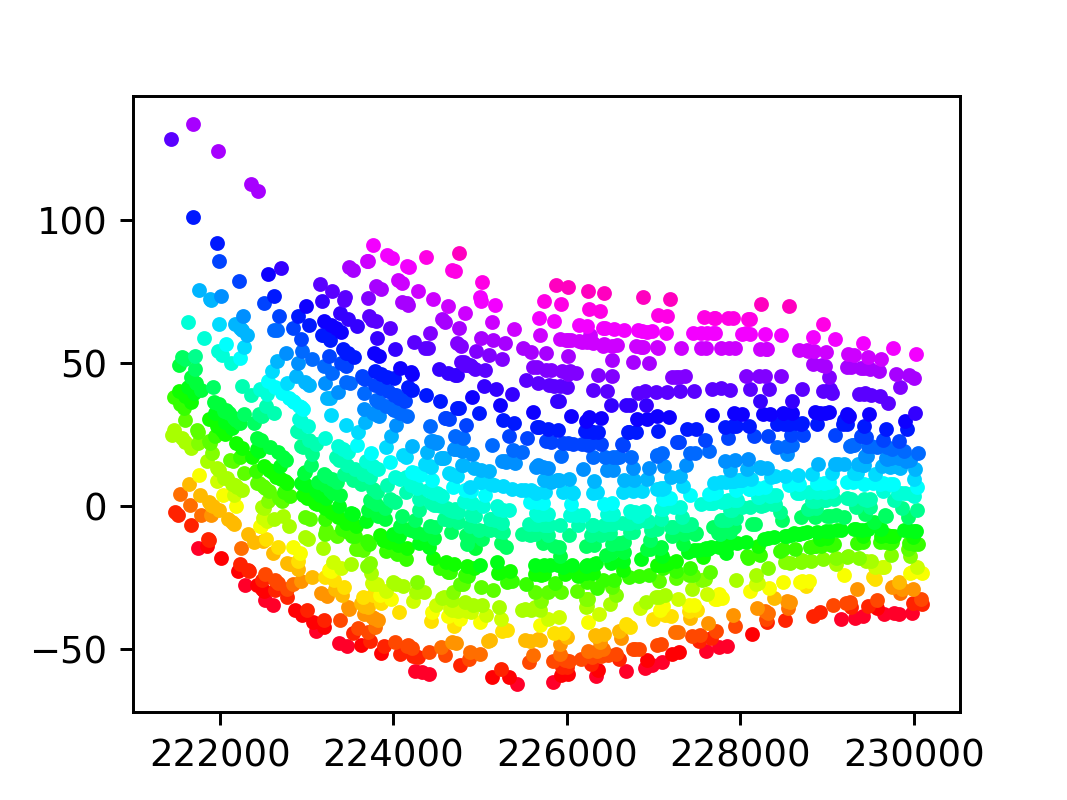

In [73]:
p = data.fit_global_polynomial(order_ol=4)
ol = data.ol
res_1 = data.x - data.eval_polynomial(ol, data.o)
# plotting the residuum
plt.figure(figsize=(4,3))
for o in data.get_orders():
    I = data.index_order(o)
    plt.plot(ol[I], res_1[I], '.', color=data.color_of_order(o))

In [74]:
n = len(data.o)
data.sigma_clipping()
m = len(data.o)
print('number of datapoints before: ', n, '\nnumber of datapoints after:    ', m)

number of datapoints before:  1606 
number of datapoints after:     1606


<IPython.core.display.Javascript object>


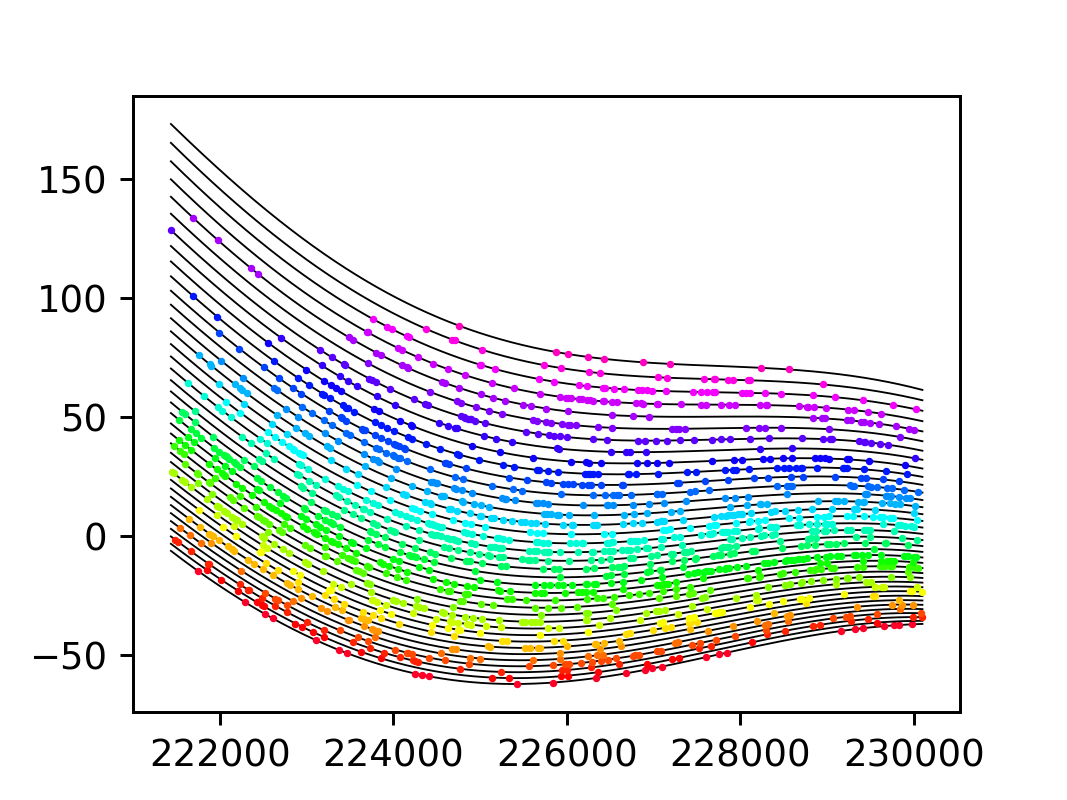

In [75]:
pglobal = data.fit_global_polynomial(order_ol=4)
data.fit_2d_polynomial()
ols = np.linspace(data.ol.min(), data.ol.max(), 1024)
res = data.eval_polynomial(data.ol, data.o) - pglobal(data.ol)

# plotting the residuum
plt.figure(figsize=(4,3))
for o in data.get_orders():
    I = data.index_order(o)
    plt.plot(ols, data.eval_polynomial(ols, o*np.ones(ols.shape)) - pglobal(ols), '-k', linewidth=0.5)
    plt.plot(data.ol[I], res[I], '.', color=data.color_of_order(o), markersize=2)

In [ ]:
ol = data.ol
res = data.x - data.eval_polynomial(ol, data.o)
# plotting the residuum
plt.figure(figsize=(4,3))
for o in data.get_orders():
    I = data.index_order(o)
    plt.plot(ol[I], res[I], '.', color=data.color_of_order(o))

In [ ]:
wavelist = data.get_lambda_list()
plt.figure(figsize=(4,3))
for i, o in enumerate(data.get_orders()):
    plt.plot(np.arange(i*7800, (i+1)*7800), wavelist[i*7800:(i+1)*7800], '.', color=data.color_of_order(o))

reducing by linear $o$ dependency
$$
x = P_1(ol)+P_2(o)
$$
Degree of $P_1$ is $4$, degree of $P_2$ is $2$.

In [ ]:
fit_polynomial2 = np.polynomial.Polynomial.fit(data.o, res_1, deg=2)
res_2 = res_1 - fit_polynomial2(data.o)
# plotting the residuum
plt.figure(figsize=(4,3))
for o in data._orders: # original orders...
    I = data.index_order(o)
    plt.plot(ol[I], res_2[I], '.', color=data.color_of_order(o))
    
# single out the strange order....(plotted in cyan)
o = 54
I = data.index_order(o)
plt.plot(ol[I], res_2[I], '.', color='k')
plt.show()

Analysing residuum around polynomial for each order

In [ ]:
n =  6 # order of polynomial
bins_abs = np.linspace(-1, 1, 21)
bins_rel = np.linspace(-5, 5, 21)
for o in data.get_orders():
    I = data.index_order(o)
    sig = np.sqrt(0.01 + data.sigma**2)
    p = np.polynomial.Polynomial.fit(sg.link_ol(ol[I]), data.x[I], n, w=1./sig[I])
    res = (data.x[I] - p(sg.link_ol(ol[I])))
    #pd.cut(res, np.linspace(-4,4,5))
    #res.hist(bins=10)
    plt.figure(figsize=(5,2))
    plt.subplot(131)
    plt.title('abs '+str(o))
    plt.hist(res, bins=bins_abs, range=(-0.5, 0.5))
    plt.subplot(132)
    plt.title('rel ' + str(o))
    plt.hist(res/sig[I], bins=bins_rel, range=(-5,5))
    plt.subplot(133)
    #plt.plot(data.l[I], res, '.', color=)
plt.show()

### Outlier removal order by order
criteria: absolut $\epsilon < \sigma_a$ and relative $\epsilon/\sigma < \sigma_r$ 
We convert $\sigma_a$ in errors of radial velocity using the formula
$$
\delta_{rv} = \gamma_o \,\sigma_a,\quad \gamma_o = 3\cdot 10^8 \frac{d\lambda/dx}{\lambda} = \frac{3\cdot 10^{8} }{\lambda |dx/d\lambda|_o}=\frac{3\cdot 10^{8} \cdot o }{\lambda |\partial_{o\lambda}x(o\lambda, o)|}
$$
where $x=x(o\lambda, o)$ is taken in linear global approximation

In [ ]:
sigma_a = 0.5
sigma_r = 3
orders = data.get_orders()

# global linear approximation
p_lin = np.polynomial.Polynomial.fit(data.ol, data.x, deg=1)
gamma_o = {o: o * 3e8 / (data.l[data.index_order(o)].mean() * p_lin.coef[1]) for o in data.get_orders()}
gamma = o * 3e8 / (data.l * p_lin.coef[1])
plt.figure(figsize=(5,4))
for o in orders:
    plt.plot( [o], [gamma_o[o]], 'o', color=data.color_of_order(o))
plt.xlabel('order')
plt.ylabel('average $\gamma$ factor')
plt.show()

Therefore with a target resolution of $100 m/s$ the reuired precision depending on the order needs to be adjusted 

In [ ]:
delta_vr = np.linspace(0, 200, 50)
Io = np.any([data.index_order(o) for o in orders], axis=0)
plt.figure(figsize=(5,4))
plt.plot(delta_vr, [ sum(gamma[Io] * data.sigma[Io] < d_vr) for d_vr in delta_vr])
plt.title('theoretical precision per data')
plt.xlabel('target rv precision')
plt.ylabel('number of usable spectral lines')
plt.show()

In [ ]:
delta_vr = np.linspace(0, 200, 50)
Io = np.any([data.index_order(o) for o in orders], axis=0)
plt.figure(figsize=(5,4))
for o in orders:
    I = data.index_order(o)
    plt.plot(delta_vr, [ sum(gamma[I] * data.sigma[I] < d_vr) for d_vr in delta_vr], color=data.color_of_order(o))
plt.title('theoretical precision per data order by order')
plt.xlabel('target rv precision')
plt.ylabel('number of usable spectral lines')
plt.show()

### 2D modeling

Data is $x_n = g(o_n\lambda, o_n) + f_{o_n}(o_n\lambda_n) + \epsilon_n$ with orders $o_n \in [22, 58]$.
We take the global shape model $g$ of the form
$$
g(o\lambda,o) = \sum_{k=0}^{N_k}\sum_{i=0}^{N_i} C_{kmi} \tilde T_i(o) \tilde T_k(o\lambda)
$$
with degree $N_k=2$ and $N_i=1$. This covers the space of full 2s polynomials of this low degree. This part has a Bayesian prior which is flat so this this part adapts freely
$$
\mathbb{P}(C) \sim 1
$$
The individual fluctuations $f_o$ for each order are higeher degree polynomials.
$$
f_o = \sum_{m=0}^{N_r} D_{o, m} \tilde T_m 
$$
Here smootheness constraints are added.
First we penalise the total size of fluctuations
$$
\sum_o \Vert f_o\Vert^2 = \sum |D_{o,m}|^2
$$
The difference between sucessive orders is controlled by
$$
\sum_o \Vert f_{o+1}-f_o \Vert^2 = \sum |D_{o+1,m}|^2 + |D_{o,m}|^2 - 2D_{o+1,m}D_{o,m}
$$
Here we have used the orthogonality of the Chebushev polynomials. 
To controll higher order smoothness in $o$ direction we also conisder the discrete Laplacian
$$
\sum_o \Vert f_{o+2}-2f_{o+1} + f_o \Vert^2 =
\sum |D_{o+2, m}|^2 + 4|D_{o+1, m}|^2 + |D_{o,m}|^2 - 2 D_{o+2,m}D_{o+1,m} - 2 D_{o+1, m} D_{o,m} + D_{o+2,m}D_{o,m}
$$
These terms are quadratic forms, that can be cast into a matrix equation as
$$
\sum_o \Vert f_o\Vert^2 = D^T \mathbb{I} D,\quad \sum_o \Vert f_{o+1}-f_o \Vert^2 = D^T\Gamma D,\quad
\sum_o \Vert f_{o+2}-2f_{o+1} + f_o \Vert^2 = D^T \Xi D
$$

In [ ]:
Ni = 8 # orders of o
Nk = 7 # orders of ol

Nr = 10 # degree in olambda direction

olrange = (ol.min(), ol.max())
orange = (orders.min(), orders.max())
I = np.identity(Nr+1)
# Computing all Tchebyshev polynomials we need in ol
Tsheb = [np.polynomial.chebyshev.Chebyshev(c, window=[-1,1], domain=olrange) for c in I]

I = np.identity(Ni+1)
Tshebo = [np.polynomial.chebyshev.Chebyshev(c, window=[-1,1], domain=orange) for c in I]
ndata = len(data.data) # number of data
G = np.zeros((ndata, (Nk+1)*(Ni+1)))

ik = [(i, k) for i in range(Ni+1) for k in range(Nk+1)] # this fixes the order of basis

for u, olol in enumerate(zip(ol, data.o)):
    ooll, o = olol
    for v, j in enumerate(ik):
        i, k = j
        G[u, v] = Tshebo[i](o)*Tsheb[k](ooll)

s = 1./np.sqrt((1/gamma)**2 + data.sigma**2)

def get_Gsme(I):
    s = 1./np.sqrt((1/gamma)**2 + data.sigma**2)
    return s[I][:, np.newaxis] * G[I,:]

def fit_free_model(I):
    smeG = get_Gsme(I)
    C = np.linalg.lstsq(smeG, s[I] * data.x[I])[0]
    return C, G



## sigma clipping based on RV limit on each spectral line

In [ ]:
target_rv = 100
I = Io
Iold = I
change = True

rv = 10000

while change:
    C, G = fit_free_model(I)
    dx = data.x - np.dot(G,C)
    I = gamma * dx <= rv
    I = I & Io
    change = (not np.all( Iold == I)) | rv>target_rv
    Iold = I
    rv = int(0.2*(target_rv+1 + 4*rv)-0.1)

Isigma_clipped = I
print('remaining number of points', sum(I), rv)

C, G = fit_free_model(Isigma_clipped)

res_5 = data.x[Io] - np.dot(G,C)[Io]
res_5
plt.figure(figsize=(3,1))
plt.hist(gamma[Io]*res_5, bins=np.linspace(-1000,1000,30))
plt.show()

def g(ol, o):
    return sum([C[l]*Tshebo[ii](o) * Tsheb[kk](ol) for l, (ii, kk) in enumerate(ik)])

def ggo(o):
    """
    Chebysheb series at given o
    """
    return sum([C[l]*Tshebo[ii](o) * Tsheb[kk] for l, (ii, kk) in enumerate(ik)])

def ig(x, o):
    """
    input:
    :x: pixel position
    :o: order
    returns: 
    :ol: order X lambda
    """
    # first order proxy
    lloo = (C[0]*Tsheb[0]+C[1]*Tsheb[1]-x).roots()[0]
    # polynome to solve
    gg = ggo(o) - x
    rts = gg.roots() # all roots
    I = np.argmin(np.abs(rts-lloo))  # getting zero closest to lloo
    return np.real(rts[I])

res = data.x - g(ol, data.o)
plt.figure(figsize=(4,3))
for o in orders:
    I = data.index_order(o) & Isigma_clipped
    plt.plot(ol[I], res[I], '.', color=data.color_of_order(o))

In [ ]:
# p = np.polynomial.Polynomial.fit(ol[Isigma_clipped], data.x[Isigma_clipped], deg=4) 
# for plotting
# alternatively the firs
p = lambda ol: g(ol, min(orders))
res = data.x[Isigma_clipped] - p(ol[Isigma_clipped])

plt.figure(figsize=(4,3))
ols = np.linspace(ol.min(), ol.max(), 1024)
for o in set(data.o):
    I = data.index_order(o) & Isigma_clipped
    ols = np.linspace(ol.min(), ol.max(), 1024)
    plt.plot(ols, g(ols, o) - p(ols), '-.', color='k', linewidth=0.5)
    ols = np.linspace(ol[I].min(), ol[I].max(), 1024)
    plt.plot(ols, g(ols, o) - p(ols), '-', color=data.color_of_order(o))
    plt.plot(ol[I], res[I], '.', color=data.color_of_order(o))
plt.ylim(0,175)
plt.show()


In [ ]:
x = np.arange(74)
oo = np.arange(data.o.min(), data.o.max()+1)
ordermap = [ ig(xx,o)/o for o in oo for xx in x ]

In [ ]:
import scipy.interpolate as scip
olams = np.linspace(ol.min()/1.01, 1.01*ol.max(), 10007)
x = np.arange(7800)

res = []
wavemap = {}
for o in data.get_orders():
    # g(o*lams, o) # liefert zu den lams die x
    p = scip.interp1d( g(olams, o), olams)
    tmp = list(p(x)/o)
    wavemap[o] = np.array(tmp)
    res += tmp
res = np.array(res)

In [ ]:
plt.figure(figsize=(3,2))

plt.plot(res, '.')

In [ ]:
# poor mans inversi
res = np.zeros(39*7800)
i = 0
for o in range(21, 60):
    print('working on order ', o)
    for x in range(7800):
        res[i] = ig(x, o)/o
        i +=1
res

In [ ]:
xx = np.arange(len(ordermap))
plt.figure(figsize=(3,2))

plt.plot(np.mod(xx,74), ordermap, '.')
plt.show()

# Two dimensional modeling

In [ ]:
ik

In [ ]:
(300+sum(np.array([1,2,-3]) * Tsheb[:3])).roots()

In [ ]:
sum(np.array([1,2,-3]) * Tsheb[:3])(np.array([195696.38775984, 257292.42171349]))

In [ ]:
Gs = get_Gsme(Isigma_clipped)
GtG = np.dot(Gs.T,Gs)

def var_ol_o(ol, o):
    """
    posterior variance / estimation variance at ol, o
    """
    xx = [Tshebo[ii](o)*Tsheb[kk](ol) for (ii,kk) in ik ]
    return np.dot(xx, np.linalg.solve(GtG,xx))

np.sqrt(var_ol_o(222000, 55))

# FP analysis

In [4]:
kwargs.update({'fp_file': 'FP_voie_3.dat.json', 'ccd2d' : data, 
              'cutoff_fp_flux' : 100,
              'fp_window': 3})

import spectrograph as sg
fp = sg.FP(**kwargs)

<IPython.core.display.Javascript object>


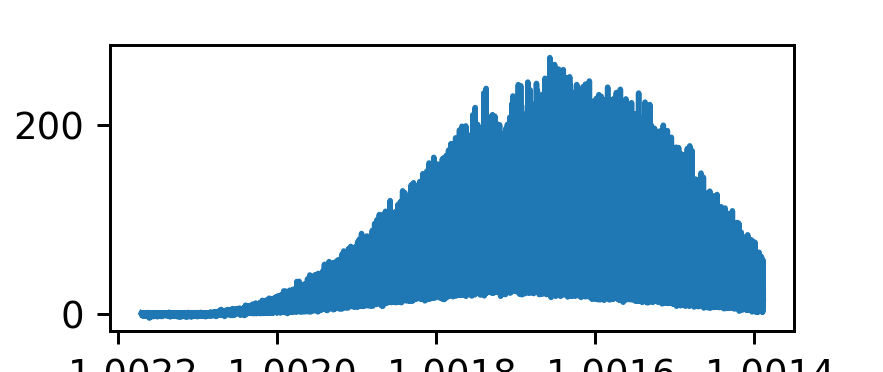

In [6]:
# checking the data
plt.figure(figsize=(3,2))
t = 1./fp.lam_at_order(55)
plt.plot(t / np.median(t[1:]-t[:-1]), fp.flux_at_order(49))

<IPython.core.display.Javascript object>


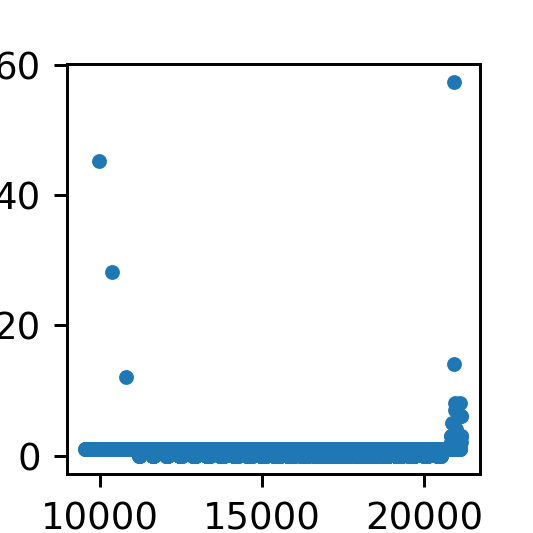

In [128]:
tmp=pd.concat([
    pd.DataFrame({'peakf': pd.Series(tf['peakf'][tf['locmax']]), 
                  'o': o,
                 }) 
                for o, tf in [(o, fp.extract_fp_peaks_at_order(o)) 
                    for o in fp.ccd.get_orders()
                ] 
    ]).sort_values(by='peakf')
#tmp.reset_index(inplace=True)
tmp['d'] = tmp['peakf'].diff()
tmp['dd'] = tmp['d']/tmp['d'].median()
tmp['ndd'] = np.int64(tmp['dd'].round())
tmp['ndd'].iloc[0] = 0
tmp['mm'] = tmp['ndd'].cumsum()

plt.figure(figsize=(2,2))
plt.plot(tmp['peakf'].values/tmp['d'].median(), tmp['dd'].values, '.')

<IPython.core.display.Javascript object>


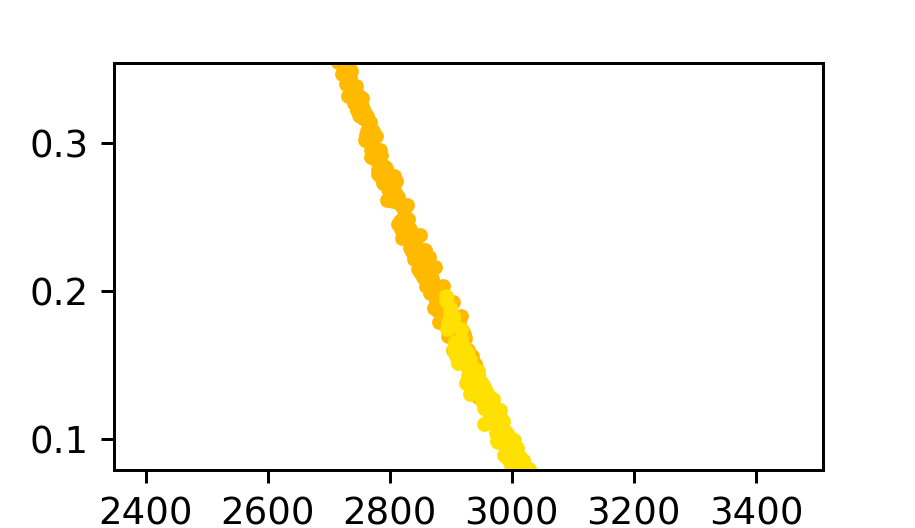

In [56]:
try:
    tmp = tmp.set_index(['o'])
except:
    pass
p = np.polynomial.Polynomial.fit(tmp['mm'], tmp['peakf'], deg=1)

plt.figure(figsize=(3,2))
for o in set(tmp.index):
    plt.plot(tmp['mm'].loc[o], (tmp['peakf'].loc[o]-p(tmp['mm'].loc[o]))/tmp['d'].median(), '.', color=fp.ccd.color_of_order(o))


In [143]:
tmp = tmp.reset_index()
tmp = tmp.set_index(['mm', 'o'])
tmp.loc[[50], 'peakf']

mm  o 
50  23    0.0001
Name: peakf, dtype: float64

In [147]:
tmp.index

MultiIndex([(    0, 23),
            (    1, 23),
            (    2, 23),
            (    3, 23),
            (    4, 23),
            (    5, 23),
            (    6, 23),
            (    7, 23),
            (    8, 23),
            (    9, 23),
            ...
            (11481, 50),
            (11482, 50),
            (11484, 50),
            (11492, 50),
            (11495, 50),
            (11501, 50),
            (11503, 50),
            (11509, 50),
            (11512, 50),
            (11515, 50)],
           names=['mm', 'o'], length=14371)

In [ ]:
plt.figure(figsize=(3,2))
tmp = 1./fp.extract_fp_peaks_at_order(49)
d = np.abs(tmp[1:]-tmp[:-1])
plt.plot(d/np.median(d))

In [ ]:
import json
import numpy as np
fpdata = json.load(open('FP_voie_3.dat.json','r'))

def flux_at_order(o):
    return np.array(fpdata[o-23]['flux3'])

def local_maxima_pixel(o):
    flux = flux_at_order(o)
    I, = np.where(np.logical_and(flux[:-2] <= flux[1:-1], flux[1:-1]>=flux[2:]))
    I +=1
    
    I = I[flux[I]>50] # simple spourious maxima removal
    r = 3
    snipp = flux[(I[:, np.newaxis] + np.arange(-r,r+1)).T]
    p = np.polyfit(np.arange(-r,r+1), snipp, deg=2)
    delta = -p[1]/(2*p[0])
    n = np.arange(len(flux))
    pixpos = n[I]+delta
    return pixpos

def local_maxima_lamda(o):
    pixpos = local_maxima_pixel(o)
    p = data.lambda_map_at_o(o)
    return p(pixpos)

def d1(x):
    return x[1:]-x[:-1]

def local_median(t, n=50):
    return np.median(t)


def match(t, mt, u, mu):
    
    dt = None
    if np.max(t) < np.min(t):  # overlap
        pass
        
def relative_orders(lot, n=50):
    """
    lot: list of times
    """
    
    m = np.arange(len(times))
    while True:
        dt = local_median(d1(times)/(1+d1(m)), n)
        
        
        
    dtimes = d1(times)
    #nn = pd.where(dtimes<)
    dt = np.median(d1(times)[:n])
    res = [0]
    m = 0
    for i in range(n):
        times[i+1]-times[i]

In [ ]:
# local maxima
order = 52
norder =  order - 23
r = 3 # -r : r+1 for local snippet
lam = np.array(fpdata[norder]['wave3'])
flux = np.array(fpdata[norder]['flux3'])
I, = np.where(np.logical_and(flux[:-2] <= flux[1:-1], flux[1:-1]>=flux[2:]))
I +=1


fpdata[norder]['true_order_number']

In [ ]:
plt.figure(figsize=(4,3))
plt.plot(flux[I], '.')

In [ ]:
I = I[flux[I]>10]

In [ ]:
plt.figure(figsize=(4,3))
plt.plot(lam, flux)
plt.vlines(lam[I], 0, 1500, color='r')
plt.xlim(lam[I].min(), lam[I].min()+10)
plt.show()

In [ ]:
plt.figure()
plt.plot(I[:-1], I[1:]-I[:-1])

In [ ]:
snipp = flux[(I[:, np.newaxis] + np.arange(-r,r+1)).T]
snipl = lam[(I[:, np.newaxis] + np.arange(-r,r+1)).T]

In [ ]:
plt.figure(figsize=(4,2))
for i in range(40):
    s = snipp[:, i]
    plt.plot(s)

In [ ]:
p = np.polyfit(np.arange(-r,r+1), snipp, deg=2)

In [ ]:
p.shape

In [ ]:
delta = -p[1]/(2*p[0])

In [ ]:
plt.figure(figsize=(3,3))
plt.plot(flux)
n = np.arange(len(flux))
plt.vlines(n[I]+delta, 0, 500, color='r')
plt.xlim(I[330]-30, I[340]+30)
plt.show()

In [ ]:


pixpos = n[I]+delta

plt.figure(figsize=(3,2))
plt.plot(pixpos[1:]-pixpos[:-1], '.')
plt.show()

In [ ]:
plt.figure(figsize=(4,3))
plt.plot(delta, '-')

In [ ]:
np.interp(n, lam)
plt.figure()
plt.plot(n[I] + delta)

In [ ]:
wavemap = data.get_lambda_map()
o = data.get_orders()

n = 20
oo = o[n]

print(oo)
#lam1 = np.array(fpdata[norder]['wave3'])
flux1 = np.array(fpdata[n]['flux3'])
#lam2 = np.array(fpdata[norder+1]['wave3'])
flux2 = np.array(fpdata[n+1]['flux3'])

plt.figure(figsize=(4,2))
plt.plot( wavemap[oo], flux1)
plt.plot( wavemap[oo+1], flux2)
#plt.xlim((5150, 5220))
#plt.plot(flux1)
#plt.plot(flux2)

In [ ]:
plt.figure(figsize=(3,4))
plt.plot(wavemap[23])
plt.plot(wavemap[24])

In [ ]:
n = np.arange(7800)


llams = []

plt.figure(figsize=(4,3))
for norder, o in enumerate(data.get_orders()):
    lam = np.array(fpdata[norder]['wave3'])
    flux = np.array(fpdata[norder]['flux3'])
    I, = np.where(np.logical_and(flux[:-2] <= flux[1:-1], flux[1:-1]>=flux[2:]))
    I +=1
    I = I[flux[I]>50]
    
    r = 3
    snipp = flux[(I[:, np.newaxis] + np.arange(-r,r+1)).T]
    p = np.polyfit(np.arange(-r,r+1), snipp, deg=2)
    delta = -p[1]/(2*p[0])

    pixmap = data.lambda_map_at_o(o)
    pixpos = n[I]+delta
    
    lams = pixmap(pixpos)
    llams += list(lams)
    
    d = 0.5 * lams[1:]*lams[:-1]/(lams[1:]-lams[:-1])
    
    print (o, np.median(d))
    
    plt.plot( 0.5*(lams[:-1]+lams[1:]),d, '.', 
             color=data.color_of_order(o), 
             markersize=0.5)
    #plt.ylim([0, 0.25e-7])
    
    #plt.plot(1/lams)

In [ ]:
m = np.arange(300, 1000)
d = 1 + 0.01*np.sin(m/200)
lam = 2*d/(1.0*m)

dd = -2*(lam[1:]-lam[:-1])/ (lam[1:]*lam[:-1])



plt.figure(figsize=(2,1))
# plt.plot(dd)
plt.plot( lam[:-1], dd)
plt.plot( lam[:-1], d[:-1])
plt.ylim([0.5, 1.2])

In [ ]:
plt.figure(figsize=(3,2))
llams = np.array(llams)
dllams = llams[1:]/(llams[1:]-llams[:-1])

plt.plot(dllams, '.')

In [ ]:
plt.figure(figsize=(3,2))
for o in data.get_orders():
    I = data.index_order(o)
    p = data.lambda_map_at_o(o)
    lpol = p(data.x[I])
    lms  = data.l[I]
    rms = 3e7 * (lpol-lms)/lms
    plt.plot(lms, rms, '.', color = data.color_of_order(o))

In [ ]:
plt.figure(figsize=(3,2))
data.fit_2d_polynomial()
for o in data.get_orders():
    I = data.index_order(o)
    p = data.polynomial_fit[o]
    xpol = p(o*data.l[I])
    plt.plot(data.l[I], (xpol-data.x[I])/data.sigma[I], '.', color = data.color_of_order(o))

In [ ]:
plt.figure()
plt.plot(data.sigma)

In [ ]:
o = 40
data.fit_2d_polynomial()
pixpos = local_maxima_pixel(o)
p = data.lambda_map_at_o(o)

lams = p(pixpos)
m = m0 - np.arange(len(lams))

plt.figure(figsize=(3,2))

for o in data.get_orders():
    pixpos = local_maxima_pixel(o)
    p = data.lambda_map_at_o(o)

    lams = p(pixpos)
    ilams =  1./lams
    mm0 = np.arange(5000, 25000)
    m = mm0[np.newaxis,:] - np.arange(len(lams))[:, np.newaxis]
    
    d = ilams[:,np.newaxis] / m
    
    i = np.argmin(np.std(d, axis = 0))
    
    # print(mm0[i])

    plt.plot(lams, 0.5*m[:, i]/ilams)
    
    #m = np.arange(len(lams))
    #ilams = 1/lams
    #plt.plot(0.5/(ilams[1:]-ilams[:-1]), '.')

###### m0=15858
plt.figure(figsize=(3,2))
plt.plot()

In [ ]:
plt.figure(figsize=(3,2))

res = {}
used_orders=[]
for o in data.get_orders():
    lams = local_maxima_lamda(o)
    if lams.shape[0] == 0:
        continue
    ilams = 1./lams
    d = np.median(d1(ilams))
    dm = d1(ilams)/d
    
    jump = np.round(dm).astype('int')
    index = np.zeros_like(lams)
    index[1:]+=np.cumsum(jump[::-1])
    index = index[::-1]
    res[o] = (index, ilams)
    used_orders.append(o)

for i in range(len(used_orders[:-1])):
    o1 = used_orders[i]
    o2 = used_orders[i+1]
    index1, ilams1 = res[o1]
    index2, ilams2 = res[o2]
    
    index2 += index1.max()
    
    # match last peak...
    #i = np.argmin(np.abs(ilams2[-1], ilams))
    
    
    
    m = np.arange(-500, 500)
    p = np.polyfit(index1, ilams1, deg=1)
    
    tmp = np.polyval(p, index2[:, np.newaxis]+m[np.newaxis,:]) - ilams2[:, np.newaxis]
    i = np.argmin(np.sum(np.abs(tmp), axis=0))
    
    index2 = index2 + m[i]
    res[o2] = (index2, ilams2)
    
index, ilams = res[used_orders[0]]
p = np.polyfit(index, ilams, deg=1)
m0 = int(p[1]/p[0])


for m in range(8, 18):
    tmp = []
    for o in res:
        index, ilams =  res[o]
        d = 0.5*(m0+m+index)/ilams
        tmp+=list(d)
    mn = np.mean(tmp)
    
    for o in res:
        index, ilams = res[o]
        d = 0.5*(m0+m+index)/ilams
        plt.plot(index, d, '-', markersize=0.5, color=data.color_of_order(o))
    

In [ ]:

times = []
for o in data.get_orders():
    times += list(local_maxima_lamda(o)[::-1])
times = 1./np.array(times)

In [ ]:
#plt.figure(figsize=(2,3))
#plt.plot(times, '.')

In [ ]:
import json
import numpy as np
fpdata = json.load(open('FP_voie_3.dat.json','r'))



def flux_at_order(pf, o):
    return pf['flux3'][pf['true_order_number']==o]

def local_maxima_pixel(flux):
    I, = np.where(np.logical_and(flux[:-2] <= flux[1:-1], flux[1:-1]>=flux[2:]))
    I += 1
    
    alpha = 0.1
    fluxmin = alpha * np.max(flux[I])
    #print(fluxmin)
    fluxmin = 50
    I = I[flux[I]>fluxmin] # simple spourious maxima removal
    r = 3
    I = I[I<len(flux)-r]
    II = (I[:, np.newaxis] + np.arange(-r,r+1)).T
    
    snipp = flux[II]
    p = np.polyfit(np.arange(-r,r+1), snipp, deg=2)
    delta = -p[1]/(2*p[0])
    n = np.arange(len(flux))
    pixpos = n[I]+delta
    return pixpos

def local_maxima_lambda(flux, o):
    pixpos = local_maxima_pixel(flux)
    p = data.lambda_map_at_o(o)
    return p(pixpos)

def d1(x):
    return x[1:]-x[:-1]

def local_index(times):
    mm = np.arange(len(times))
    m = np.zeros(len(times), dtype=int)
    # times = np.array(pfdata['times'])
    #while not np.all(mm==m):
    for i in range(1):    
        m = mm
        I = d1(m)>0
        dt = np.median(d1(times)[I]/(d1(m)[I]))
        dt = np.abs(dt)
        mm = np.zeros(m.shape, dtype=int)
        tmp=np.round(d1(times)/dt)
        mm[1:] = np.cumsum(tmp)
    
    #pfdata['m'] = mm
    return mm

newpfdata = pd.concat([ pd.DataFrame({
        'true_order_number': int(r['true_order_number']),
        'wave3': pd.Series(r['wave3']),
        'flux3': pd.Series(r['flux3'])
    }) for r in fpdata if len(r)>0]
)


times = pd.concat( [ pd.DataFrame( {
    'times' : 1./local_maxima_lambda(
            np.array(r['flux3']), 
            r['true_order_number']),
    'true_order_number': r['true_order_number']}
    )
    for r in fpdata
])

times.sort_values(by='times', inplace=True)
times.reset_index(inplace=True)
m = local_index(times['times'].values)
times['m'] = m
plt.figure(figsize=(3,2))
p = np.polynomial.Polynomial.fit(m,times['times'], deg=1)
for o in data.get_orders():
    tmp = times[times['true_order_number']==o]
    
    I = d1(tmp['m'].values)==1
    plt.plot(tmp['m'][:-1][I], (tmp['times']-p(tmp['m']))[:-1][I]/np.median(d1(tmp['times'].values)), '-', color=data.color_of_order(o))
    #plt.plot(tmp['m'][1:][I], (tmp['times']-p(tmp['m']))[1:][I]/np.median(d1(tmp['times'].values)), '.', color=data.color_of_order(o))
    

In [ ]:
tmp = times['times'].values
plt.figure(figsize=(3,2))
for o in data.get_orders():
    plt.plot(times.index[times['true_order_number']==o][:-1], d1(tmp[times['true_order_number']==o])/np.median(d1(tmp)), color=data.color_of_order(o))

In [ ]:
#newpfdata['m'] = local_index(newpfdata['times'].values)

times = newpfdata['times']

m = local_index()
                
plt.figure(figsize=(3,2))
#times = newpfdata['times'].values
#m = np.array(newpfdata['m'])
#times = times/np.median(d1(times))
p = np.polynomial.Polynomial.fit(m, times, deg=1)
I = d1(m)==0
nI = d1(m)!=0

#plt.plot(m[:-1][I], times[:-1][I]-p(m[:-1][I]), '.')
#plt.plot(m[1:][nI], times[1:][nI]-p(m[1:][nI]), '.')

times

plt.plot(times, '.')

In [ ]:
times['times']

In [ ]:
plt.figure(figsize=(3,2))
for o in data.get_orders():
    plt.plot(newpfdata[newpfdata['true_order_number']==o]['m'].values,
             newpfdata[newpfdata['true_order_number']==o]['times'].values, '.',
            color=data.color_of_order(o))

In [ ]:
times

In [ ]:
plt.figure(figsize=(3,2))
ti=times['times'].values
m = times['m']
I = d1(m)>0
dt = np.median(d1(times)[I]/(d1(m)[I]))
tmp = d1(ti)/np.median(d1(ti))
tmp = tmp - np.round(tmp)
plt.plot(tmp, '.')

In [ ]:
plt.figure(figsize=(3,2))
for o in data.get_orders():
    I = data.index_order(o)
    plt.plot(data.eval_polynomial(data.ol[I], o) - data.x[I], '.', color=data.color_of_order(o))

In [ ]:
for o in data.get_orders():
    I = data.index_order(o)
    print ("order", o, "ndata ", sum(I))
    print ( " ".join([str(np.quantile(data.sigma[I]*gamma[I], alpha)) 
                      for alpha in [0.25, 0.5, 0.75]]))


#plt.figure(figsize=(3,2))
#plt.hist(data.sigma*gamma, bins=250)

In [ ]:
delta = data.eval_polynomial(data.ol, data.o) - data.x

for o in data.get_orders():
    I = data.index_order(o)
    print(o, np.sqrt(np.mean(delta[I]**2*gamma[I]**2)))

In [ ]:
delta = data.eval_polynomial(data.ol, data.o) - data.x

for o in data.get_orders():
    I = data.index_order(o)
    print(o, np.sqrt(np.mean(delta[I]**2)))

In [ ]:
data.sigma_clipping()
plt.figure(figsize=(3,2))
o = 40
I = data.index_order(o)
oll = np.linspace(data.ol.min(), data.ol.max(), 1024)
#plt.plot(oll, data.polynomial_fit[o](oll), '-k')
plt.vlines(data.ol[I], ymin=-2*data.sigma[I], ymax=2*data.sigma[I], color='r')
plt.plot(data.ol[I], data.x[I]-data.polynomial_fit[o](data.ol[I]), 'o')


In [ ]:
data.data.sort_values(by='ref_lambda', inplace=True)

In [ ]:
tmp = data.data.copy()

In [ ]:
tmp['true_order_number'].plot()

In [ ]:
tmp['true_order_number'].diff(2).tail()

In [ ]:
data1 = pd.read_json('NEO_20220512_084045_th2.fits_voie1.json')
data2 = pd.read_json('NEO_20220512_103717_th2.fits_voie1.json')
data3 = pd.read_json('NEO_20220512_090157_th2.fits_voie1.json')
data4 = pd.read_json('NEO_20220512_080859_th2.fits_voie1.json')

In [ ]:
data1.iloc[0]

In [ ]:
data2.iloc[0]

In [ ]:
data3.iloc[0]

In [ ]:
data4.iloc[0]

In [ ]:
plt.figure(figsize=(3,2))
plt.plot(data1['pixels_extract'].iloc[0], data1['flux_values_extract'].iloc[0])
plt.plot(data2['pixels_extract'].iloc[0], data2['flux_values_extract'].iloc[0])
plt.plot(data3['pixels_extract'].iloc[0], data3['flux_values_extract'].iloc[0])
plt.plot(data4['pixels_extract'].iloc[0], data4['flux_values_extract'].iloc[0])


In [ ]:
data1

In [ ]:
data.data.iloc[0]